In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import glob 


from sklearn import datasets, ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import json

import xgboost as xgb
from bayes_opt import BayesianOptimization
# import shap

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.util import add_cyclic_point

In [2]:
wr_original_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_v20241226.csv',\
                index_col=0,names=['week0','dist'],skiprows=1,parse_dates=True)
# Rolling window for mode
rolling_mode = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: x.mode()[0] if not x.mode().empty else float('nan'))
).shift(-3)

# Rolling window for the count of the mode
rolling_mode_count = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: (x == x.mode()[0]).sum() if not x.mode().empty else 0)
).shift(-3)

# If duration of WR during week was less than 4, assing NO WR class
rolling_mode.loc[rolling_mode_count['week0']<4,'week0'] = 4
wr_series_mode = copy.deepcopy(rolling_mode)
time_index = pd.to_datetime(wr_series_mode.index).dayofweek
wr_series_mode = wr_series_mode.iloc[time_index.isin([0,3])].dropna()
wr_series = copy.deepcopy(wr_series_mode)

for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [3]:
list_files_anoms = np.sort(glob.glob('/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/*.nc'))
list_vars = [list_files_anoms[i].split('/')[-1][:-3] for i in range(len(list_files_anoms))]

for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [4]:
indices_vars_atm = [8,21,22,23]
indices_vars_ocn = [0,1,2,3,4,5,6,7,10,12]
indices_vars_lnd = [9,13,14,15,16,17,18,19,20]

In [5]:
all_indices  = np.concatenate([indices_vars_atm,indices_vars_ocn,indices_vars_lnd])

In [6]:
path_shap = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/SHAP_Results_v20241226/'
path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
path_results = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/Results_v20241226/'

In [7]:
wr_names = ['Pacific Trough', 'Pacific Ridge', 'Greenland High', 'Alaskan Ridge', 'No WR']

In [8]:
indices_seasons = {'Winter':[12,1,2],
                   'Spring':[3,4,5],
                   'Summer':[6,7,8],
                   'Fall':[9,10,11],
                   'All':[1,2,3,4,5,6,7,8,9,10,11,12]}

In [9]:
from scipy.ndimage import gaussian_filter

def nan_weighted_filter(data, size, sigma=0.5):
    # Create a mask for valid (non-NaN) values
    nan_mask = np.isfinite(data).astype(float)
    
    # Apply Gaussian filter to both data and the mask
    data_filtered = gaussian_filter(data, sigma=sigma, mode="wrap") * size**2
    mask_filtered = gaussian_filter(nan_mask, sigma=sigma, mode="wrap") * size**2
    
    # Compute the weighted mean while ignoring NaNs
    return data_filtered / mask_filtered

In [30]:
def plot_composite_in_ax(ax_temp,ivar,week_out,wr,season,letter_title,shrink=0.6):
    path_nc_anoms = f'{path_weekly_anoms}{list_vars[ivar]}.nc'
    anoms = xr.open_dataset(path_nc_anoms)
    anoms = anoms.assign_coords(time=pd.DatetimeIndex(anoms.time).normalize())
    var_name_nc = list(anoms.data_vars.keys())[0]
    week_out_str = f'week{week_out}'
    shap_full = xr.open_dataset(f'{path_shap}/SHAP_{list_vars[ivar]}_{week_out_str}.nc')
    
    df_results_full = pd.read_csv(f'{path_results}/Results_{list_vars[ivar]}_{week_out_str}.csv',
                                 index_col=0, parse_dates=True)
    df_results_temp = copy.deepcopy(df_results_full)
    if season!='All':
        df_results_temp = df_results_temp.loc[(df_results_temp.index.month==indices_seasons[season][0])|\
                        (df_results_temp.index.month==indices_seasons[season][1])|\
                        (df_results_temp.index.month==indices_seasons[season][2])]
    anoms_temp = anoms.sel(time=df_results_temp.index)
    where_correct = np.where((df_results_temp['y_predicted']==df_results_temp['y_true'])&
                            (df_results_temp['y_predicted']==wr))[0]
    if len(where_correct)==0:
        composite_plot = copy.deepcopy(anoms[var_name_nc].isel(time=0))*np.nan
    else:
        composite_plot = anoms_temp[var_name_nc]
        composite_plot = composite_plot.isel(time=where_correct)
        composite_plot = composite_plot.mean('time')#.fillna(0)
        symmetric_max = np.max(np.abs(np.max([abs(np.nanquantile(composite_plot,0.001)),\
                                              abs(np.nanquantile(composite_plot,0.999))])))
    compositevals = composite_plot.values
    compositevals[:,-1] = compositevals[:,-2]
    compositevals[0,:] = compositevals[1,:]
    compositevals[-1,:] = compositevals[-2,:]

    # ### SHAP STUFF ###
    # if season!='All':
    #     where_temp = np.where((df_results_temp.index.month==indices_seasons[season][0])|\
    #                     (df_results_temp.index.month==indices_seasons[season][1])|\
    #                     (df_results_temp.index.month==indices_seasons[season][2]))[0]
    #     df_results_temp = df_results_temp.loc[(df_results_temp.index.month==indices_seasons[season][0])|\
    #                     (df_results_temp.index.month==indices_seasons[season][1])|\
    #                     (df_results_temp.index.month==indices_seasons[season][2])]
    #     shap_temp = shap_full.isel(time=where_temp)
    # else:
    #     shap_temp = copy.deepcopy(shap_full)
    # where_correct = np.where((df_results_temp['y_predicted']==df_results_temp['y_true'])&
    #                         (df_results_temp['y_predicted']==wr))[0]
    # if len(where_correct)==0:
    #     shap_plot = copy.deepcopy(shap_full[var_name_nc].isel(time=0))*np.nan
    # else:
    #     shap_plot = shap_temp[var_name_nc]
    #     shap_plot = shap_plot.isel(time=where_correct)
    #     shap_plot = shap_plot.mean('time').fillna(0)
        
    # arr_temp = copy.deepcopy(shap_plot.values)
    # arr_temp[arr_temp==0] = np.nan
    # q = np.nanquantile(arr_temp,0.95)
    # lat_scatter = shap_plot.lat.values[np.where(arr_temp>q)[0]]
    # lon_scatter = shap_plot.lon.values[np.where(arr_temp>q)[1]]
    # shaps_scatter = arr_temp[np.where(arr_temp>q)]
    ##### Plot ####
    intervals = 41
    mini=-1
    maxi=1
    bounds=np.linspace(mini,maxi,intervals)
    # print(vmax,vmin)
    cs = ax_temp.contourf(composite_plot.lon,composite_plot.lat,\
        compositevals,cmap='seismic',
        transform=ccrs.PlateCarree(),
        vmin=mini,vmax=maxi,extend='both',levels=bounds)
    ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax_temp.margins(x=0, y=0)

    # ax_temp.scatter(lon_scatter,lat_scatter,transform=ccrs.PlateCarree(),color='k',s=20)
    # ax_temp.scatter(lon_scatter,lat_scatter,transform=ccrs.PlateCarree(),c=shaps_scatter,cmap='spring',
    #                 s=5,vmin=shaps_scatter.min(),vmax=np.quantile(shaps_scatter,0.95))
    # Add colorbar
    kwargs = {'format': '%.1f'}
    ticks_1 = [-1, -0.5, 0, 0.5, 1]
    cbar = fig.colorbar(cs, ax=ax_temp, orientation='vertical', pad=0.02, shrink=shrink,
                       spacing='proportional',ticks=ticks_1, **kwargs)
    cbar.set_label("$\sigma$")
    
    # Set geographical extent (lon_min, lon_max, lat_min, lat_max)
    ax_temp.set_extent([100, -30, -30, 90], crs=ccrs.PlateCarree())

    name_var = list_vars[ivar].replace('_ERA5','').replace('_SODA','')
    name_var = name_var.replace('SWVL','SWC').replace('STL','ST')
    ax_temp.set_title(f'{letter_title}) {name_var} Anoms. - {season} - Week {week_out}\n{wr_names[wr]} - # Correct cases: {len(where_correct)}',loc='left')    

In [31]:
def plot_shap_in_ax(ax_temp,ivar,week_out,wr,season,letter_title,shrink=0.6):
    path_nc_anoms = f'{path_weekly_anoms}{list_vars[ivar]}.nc'
    anoms = xr.open_dataset(path_nc_anoms)
    anoms = anoms.assign_coords(time=pd.DatetimeIndex(anoms.time).normalize())
    var_name_nc = list(anoms.data_vars.keys())[0]
    week_out_str = f'week{week_out}'
    shap_full = xr.open_dataset(f'{path_shap}/SHAP_{list_vars[ivar]}_{week_out_str}.nc')
    var_name_nc = list(shap_full.data_vars.keys())[0]
    df_results_full = pd.read_csv(f'{path_results}/Results_{list_vars[ivar]}_{week_out_str}.csv',
                                 index_col=0, parse_dates=True)
    df_results_temp = copy.deepcopy(df_results_full)
    if season!='All':
        where_temp = np.where((df_results_temp.index.month==indices_seasons[season][0])|\
                        (df_results_temp.index.month==indices_seasons[season][1])|\
                        (df_results_temp.index.month==indices_seasons[season][2]))[0]
        df_results_temp = df_results_temp.loc[(df_results_temp.index.month==indices_seasons[season][0])|\
                        (df_results_temp.index.month==indices_seasons[season][1])|\
                        (df_results_temp.index.month==indices_seasons[season][2])]
        shap_temp = shap_full.isel(time=where_temp)
    else:
        shap_temp = copy.deepcopy(shap_full)
    where_correct = np.where((df_results_temp['y_predicted']==df_results_temp['y_true'])&
                            (df_results_temp['y_predicted']==wr))[0]
    if len(where_correct)==0:
        shap_plot = copy.deepcopy(shap_full[var_name_nc].isel(time=0))*np.nan
    else:
        shap_plot = shap_temp[var_name_nc]
        shap_plot = shap_plot.isel(time=where_correct)
        shap_plot = shap_plot.mean('time').fillna(0)
        shap_plot = xr.apply_ufunc(
            nan_weighted_filter,
            shap_plot,
            kwargs={"size": 7},  # Adjust the window size
            input_core_dims=[["lat", "lon"]],
            output_core_dims=[["lat", "lon"]],
            vectorize=True,
        )
        arr_temp = copy.deepcopy(shap_plot.values)
        arr_temp[arr_temp==0] = np.nan
        symmetric_max = np.max(np.abs(np.max([abs(np.nanquantile(arr_temp,0.003))\
                            ,abs(np.nanquantile(arr_temp,0.997))])))
        
    # q = np.nanquantile(arr_temp,0.95)
    # arr_temp[arr_temp<q] = np.nan
    
    intervals = 41
    mini=-symmetric_max
    maxi=symmetric_max
    bounds=np.linspace(mini,maxi,intervals)
    # print(vmax,vmin)
    # cs = ax_temp.contourf(shap_plot.lon,shap_plot.lat,\
    #     arr_temp,cmap='bwr',
    #     transform=ccrs.PlateCarree(),
    #     vmin=mini,vmax=maxi,extend='both',levels=bounds)
    cs = ax_temp.pcolormesh(shap_plot.lon,shap_plot.lat,\
        arr_temp,cmap='bwr',
        transform=ccrs.PlateCarree(),
        vmin=mini,vmax=maxi)
    ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax_temp.margins(x=0, y=0)
    # Add colorbar
    kwargs = {'format': '%.1e'}
    cbar = fig.colorbar(cs, ax=ax_temp, orientation='vertical', pad=0.02, shrink=shrink,
                       spacing='proportional', **kwargs)
    cbar.set_label("SHAP Values")
    
    # Set geographical extent (lon_min, lon_max, lat_min, lat_max)
    ax_temp.set_extent([100, -30, -30, 90], crs=ccrs.PlateCarree())
    name_var = list_vars[ivar].replace('_ERA5','').replace('_SODA','')
    name_var = name_var.replace('SWVL','SWC').replace('STL','ST')
    ax_temp.set_title(f'{letter_title}) {name_var} SHAP - {season} - Week {week_out}\n{wr_names[wr]} - # Correct cases: {len(where_correct)}',loc='left')

In [14]:

for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


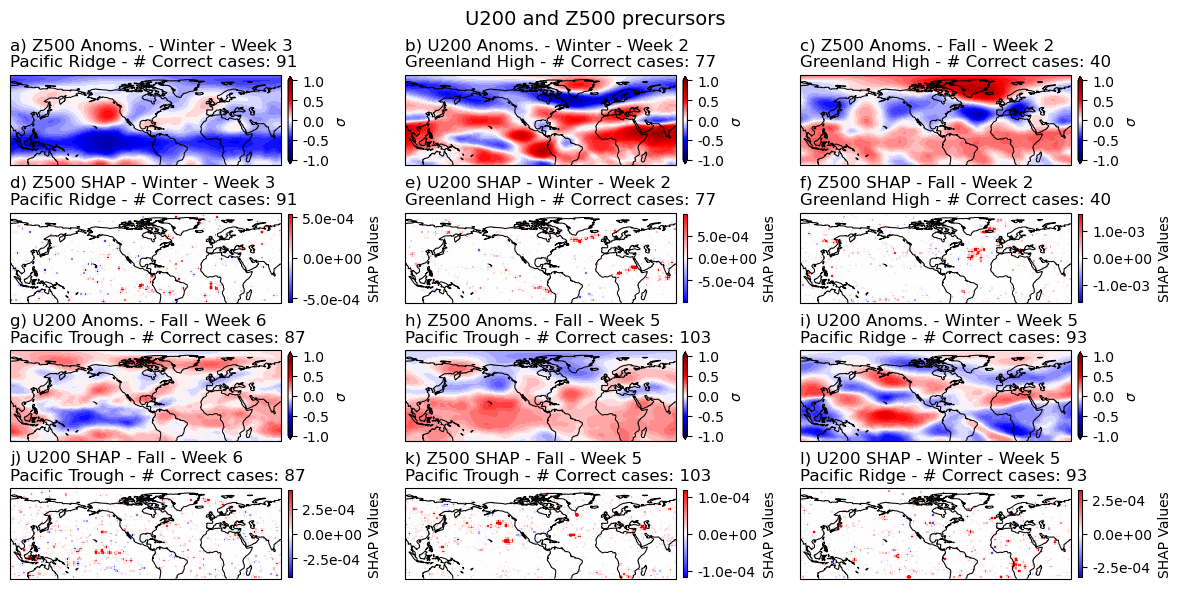

In [20]:
# fig, axs = plt.subplots(4, 3,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# # Flatten the axs array and convert to list
# axs_list = axs.flatten().tolist()

# plot_composite_in_ax(axs_list[0],23,3,1,'Winter','a')
# plot_shap_in_ax(axs_list[3],23,3,1,'Winter','d')

# plot_composite_in_ax(axs_list[1],22,2,2,'Winter','b')
# plot_shap_in_ax(axs_list[4],22,2,2,'Winter','e')

# plot_composite_in_ax(axs_list[2],23,2,2,'Fall','c')
# plot_shap_in_ax(axs_list[5],23,2,2,'Fall','f')

# plot_composite_in_ax(axs_list[6],22,6,0,'Fall','g')
# plot_shap_in_ax(axs_list[9],22,6,0,'Fall','j')

# plot_composite_in_ax(axs_list[7],23,5,0,'Fall','h')
# plot_shap_in_ax(axs_list[10],23,5,0,'Fall','k')

# plot_composite_in_ax(axs_list[8],22,5,1,'Winter','i')
# plot_shap_in_ax(axs_list[11],22,5,1,'Winter','l')

# fig.suptitle(f'U200 and Z500 precursors',fontsize=14,y=0.98)
# plt.tight_layout()
# plt.savefig('8_U200_Z500_Precursors.png')

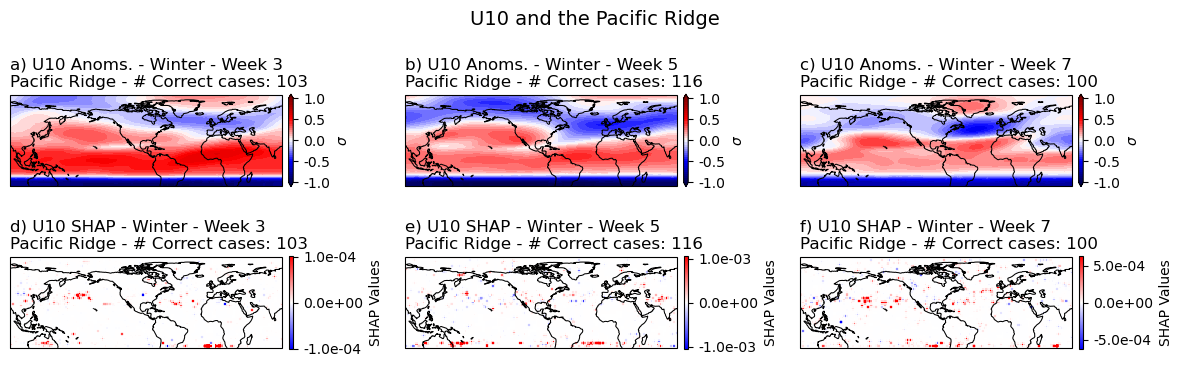

In [25]:
# fig, axs = plt.subplots(2, 3,figsize=(12,4), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# # Flatten the axs array and convert to list
# axs_list = axs.flatten().tolist()

# plot_composite_in_ax(axs_list[0],21,3,1,'Winter','a')
# plot_shap_in_ax(axs_list[3],21,3,1,'Winter','d')

# plot_composite_in_ax(axs_list[1],21,5,1,'Winter','b')
# plot_shap_in_ax(axs_list[4],21,5,1,'Winter','e')

# plot_composite_in_ax(axs_list[2],21,7,1,'Winter','c')
# plot_shap_in_ax(axs_list[5],21,7,1,'Winter','f')

# fig.suptitle(f'U10 and the Pacific Ridge',fontsize=14,y=0.98)
# plt.tight_layout()
# plt.savefig('9_U10_Precursors.png')

# QBO and SSW with PR analysis

In [366]:
### get correct dates for PR prediction
ivar = 21
season = 'Winter'
wr = 1
week_out = 5

week_out_str = f'week{week_out}'
print(f'{path_results}/Results_{list_vars[ivar]}_{week_out_str}.csv')
df_results_full = pd.read_csv(f'{path_results}/Results_{list_vars[ivar]}_{week_out_str}.csv',
                             index_col=0, parse_dates=True)
df_results_temp = copy.deepcopy(df_results_full)
where_temp = np.where((df_results_temp.index.month==indices_seasons[season][0])|\
                (df_results_temp.index.month==indices_seasons[season][1])|\
                (df_results_temp.index.month==indices_seasons[season][2]))[0]
df_results_temp = df_results_temp.loc[(df_results_temp.index.month==indices_seasons[season][0])|\
                (df_results_temp.index.month==indices_seasons[season][1])|\
                (df_results_temp.index.month==indices_seasons[season][2])]

df_correct = df_results_temp[(df_results_temp['y_predicted']==df_results_temp['y_true'])&
                        (df_results_temp['y_predicted']==wr)]

/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/Results_v20241226//Results_U10_ERA5_week5.csv


In [367]:
qbo_index = pd.read_csv('qbo.csv',index_col=0,parse_dates=True,names=['Date','QBO'],skiprows=1)
qbo_index = qbo_index.loc[(qbo_index.index.month==indices_seasons[season][0])|\
                (qbo_index.index.month==indices_seasons[season][1])|\
                (qbo_index.index.month==indices_seasons[season][2])]

In [368]:
ssw_index = pd.read_csv('ssw.txt',index_col=0,parse_dates=True).sort_index()
full_date_range = pd.date_range(start=ssw_index.index.min(), end=ssw_index.index.max(), freq='MS')
ssw_index = ssw_index.reindex(full_date_range, fill_value=0)
ssw_index = ssw_index.loc[(ssw_index.index.month==indices_seasons[season][0])|\
                (ssw_index.index.month==indices_seasons[season][1])|\
                (ssw_index.index.month==indices_seasons[season][2])]
ssw_index['ssw'] = ssw_index.sum(axis=1).values

(array([[9.15384615, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.84615385],
        [8.76923077, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.23076923],
        [7.92307692, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 2.07692308]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

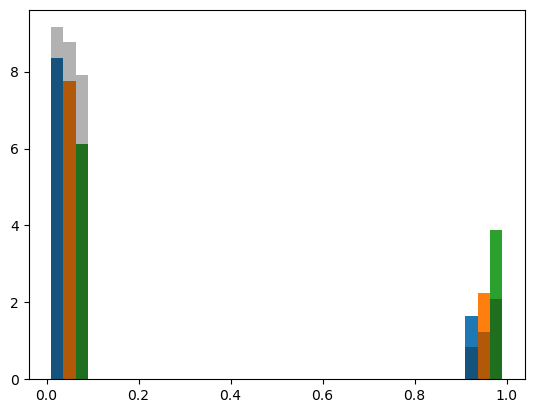

In [369]:
plt.hist(ssw_index.loc[df_correct.index.to_period("M").to_timestamp()],density=True)
plt.hist(ssw_index,density=True,color=['k','k','k'],alpha=0.3)

(array([0.00519481, 0.00692641, 0.02164502, 0.02510823, 0.02510823,
        0.03290043, 0.02510823, 0.03463203, 0.02251082, 0.0008658 ,
        0.        , 0.        ]),
 array([-30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30]),
 <BarContainer object of 12 artists>)

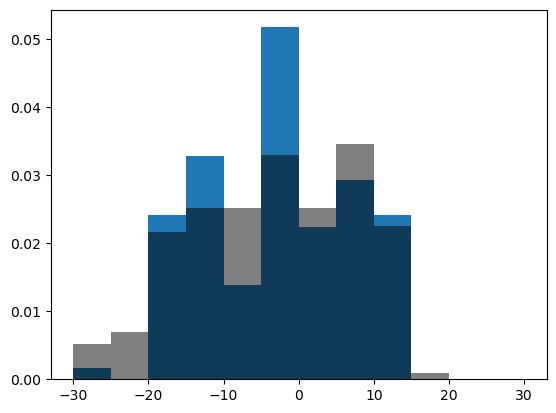

In [370]:
bins = np.arange(-30,35,5)
plt.hist(qbo_index.loc[df_correct.index.to_period("M").to_timestamp()],bins,density=True)
plt.hist(qbo_index,bins,alpha=0.5,color='k',density=True)

In [371]:
path_nc_anoms = f'{path_weekly_anoms}{list_vars[ivar]}.nc'
anoms = xr.open_dataset(path_nc_anoms)
anoms = anoms.assign_coords(time=pd.DatetimeIndex(anoms.time).normalize())
var_name_nc = list(anoms.data_vars.keys())[0]
week_out_str = f'week{week_out}'
shap_full = xr.open_dataset(f'{path_shap}/SHAP_{list_vars[ivar]}_{week_out_str}.nc')

df_results_full = pd.read_csv(f'{path_results}/Results_{list_vars[ivar]}_{week_out_str}.csv',
                             index_col=0, parse_dates=True)
df_results_temp = copy.deepcopy(df_results_full)
if season!='All':
    df_results_temp = df_results_temp.loc[(df_results_temp.index.month==indices_seasons[season][0])|\
                    (df_results_temp.index.month==indices_seasons[season][1])|\
                    (df_results_temp.index.month==indices_seasons[season][2])]
anoms_temp = anoms.sel(time=df_results_temp.index)
where_correct = np.where((df_results_temp['y_predicted']==df_results_temp['y_true'])&
                        (df_results_temp['y_predicted']==wr))[0]
# if len(where_correct)==0:
#     composite_plot = copy.deepcopy(anoms[var_name_nc].isel(time=0))*np.nan
# else:
#     composite_plot = anoms_temp[var_name_nc]
#     composite_plot = composite_plot.isel(time=where_correct)
#     composite_plot = composite_plot.mean('time')#.fillna(0)
#     symmetric_max = np.max(np.abs(np.max([abs(np.nanquantile(composite_plot,0.001)),\
#                                           abs(np.nanquantile(composite_plot,0.999))])))

In [372]:
meanu60 = anoms_temp[var_name_nc].isel(time=where_correct).sel(lat=60,method='nearest').mean('lon')
meanu0 = anoms_temp[var_name_nc].isel(time=where_correct).sel(lat=0,method='nearest').mean('lon')
meanu_15 = anoms_temp[var_name_nc].isel(time=where_correct).sel(lat=-25,method='nearest').mean('lon')

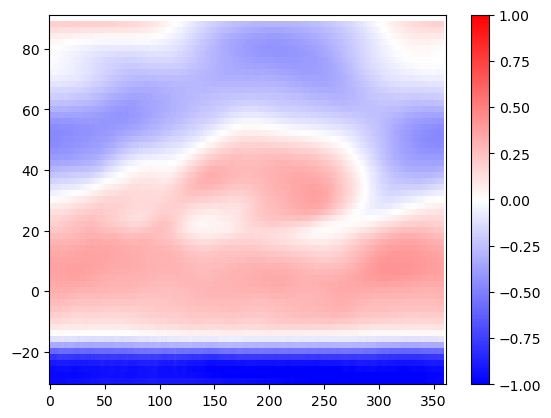

In [373]:
plt.pcolormesh(anoms_temp.lon,anoms_temp.lat,anoms_temp[var_name_nc].isel(time=where_correct).mean('time'),
               vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

(array([ 1.,  2.,  1.,  4.,  5.,  9., 16., 15.,  8.,  9.,  9., 12.,  8.,
        12.,  5.,  0.,  0.,  0.,  0.]),
 array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
        -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]),
 <BarContainer object of 19 artists>)

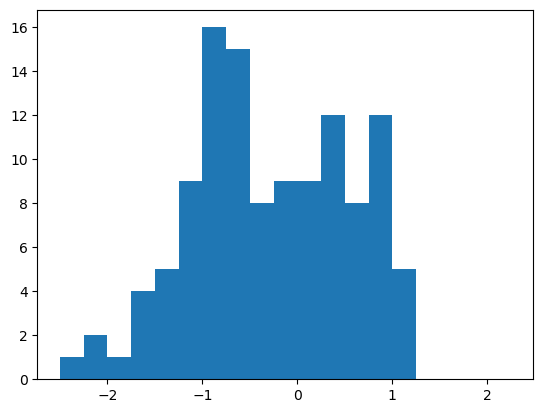

In [374]:
bins = np.arange(-2.5,2.5,0.25)
plt.hist(meanu60,bins=bins)

(array([ 0.,  0.,  0.,  0.,  8.,  7., 11., 11.,  3.,  3.,  6.,  5.,  7.,
        10., 25., 20.,  0.,  0.,  0.]),
 array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
        -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]),
 <BarContainer object of 19 artists>)

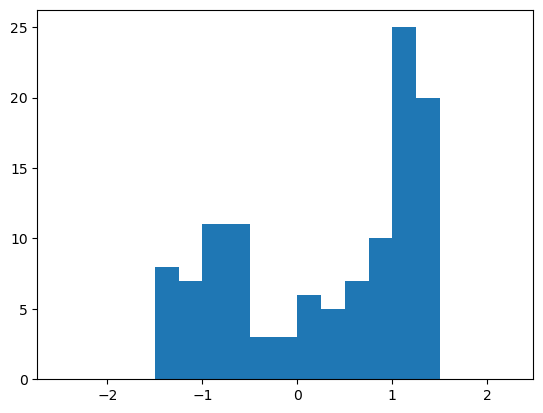

In [375]:
bins = np.arange(-2.5,2.5,0.25)
plt.hist(meanu0,bins=bins)

(array([ 0.,  2.,  9.,  8., 15., 28., 20., 13.,  6.,  9.,  3.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.]),
 array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
        -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]),
 <BarContainer object of 19 artists>)

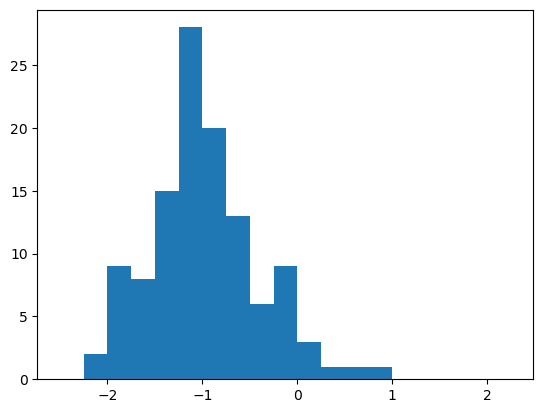

In [376]:
bins = np.arange(-2.5,2.5,0.25)
plt.hist(meanu_15,bins=bins)

# Continue with plots :)

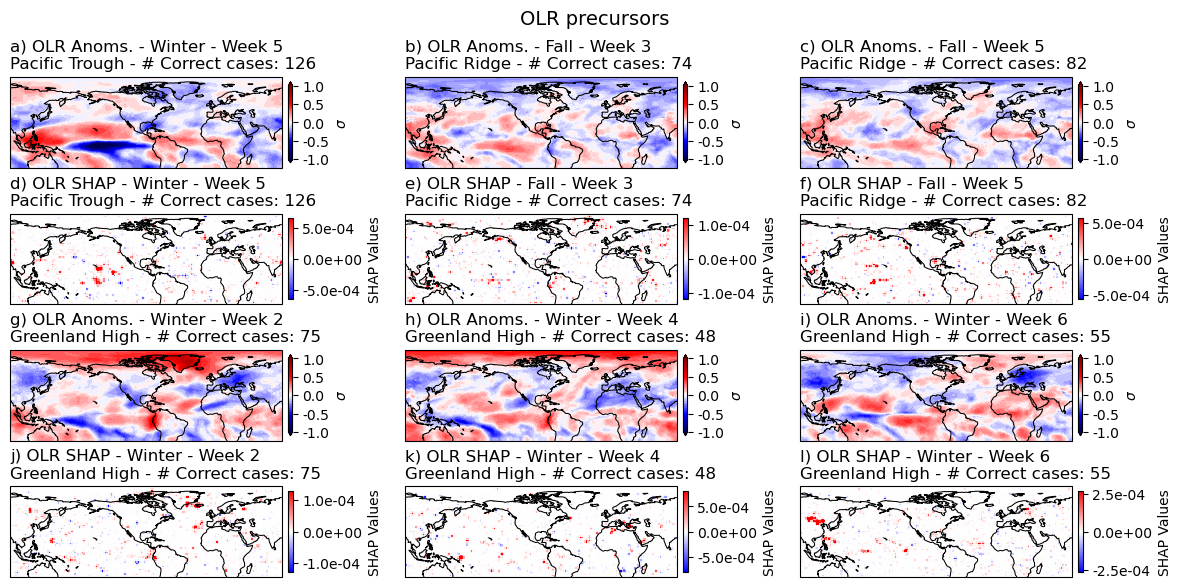

In [33]:
# fig, axs = plt.subplots(4, 3,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# # Flatten the axs array and convert to list
# axs_list = axs.flatten().tolist()

# shrink = 0.8

# plot_composite_in_ax(axs_list[0],8,5,0,'Winter','a',shrink=shrink)
# plot_shap_in_ax(axs_list[3],8,5,0,'Winter','d',shrink=shrink)
# plot_composite_in_ax(axs_list[1],8,3,1,'Fall','b',shrink=shrink)
# plot_shap_in_ax(axs_list[4],8,3,1,'Fall','e',shrink=shrink)
# plot_composite_in_ax(axs_list[2],8,5,1,'Fall','c',shrink=shrink)
# plot_shap_in_ax(axs_list[5],8,5,1,'Fall','f',shrink=shrink)

# plot_composite_in_ax(axs_list[6],8,2,2,'Winter','g',shrink=shrink)
# plot_shap_in_ax(axs_list[9],8,2,2,'Winter','j',shrink=shrink)
# plot_composite_in_ax(axs_list[7],8,4,2,'Winter','h',shrink=shrink)
# plot_shap_in_ax(axs_list[10],8,4,2,'Winter','k',shrink=shrink)
# plot_composite_in_ax(axs_list[8],8,6,2,'Winter','i',shrink=shrink)
# plot_shap_in_ax(axs_list[11],8,6,2,'Winter','l',shrink=shrink)

# fig.suptitle(f'OLR precursors',fontsize=14,y=0.98)
# plt.tight_layout()
# plt.savefig('10_OLR_Precursors.png')

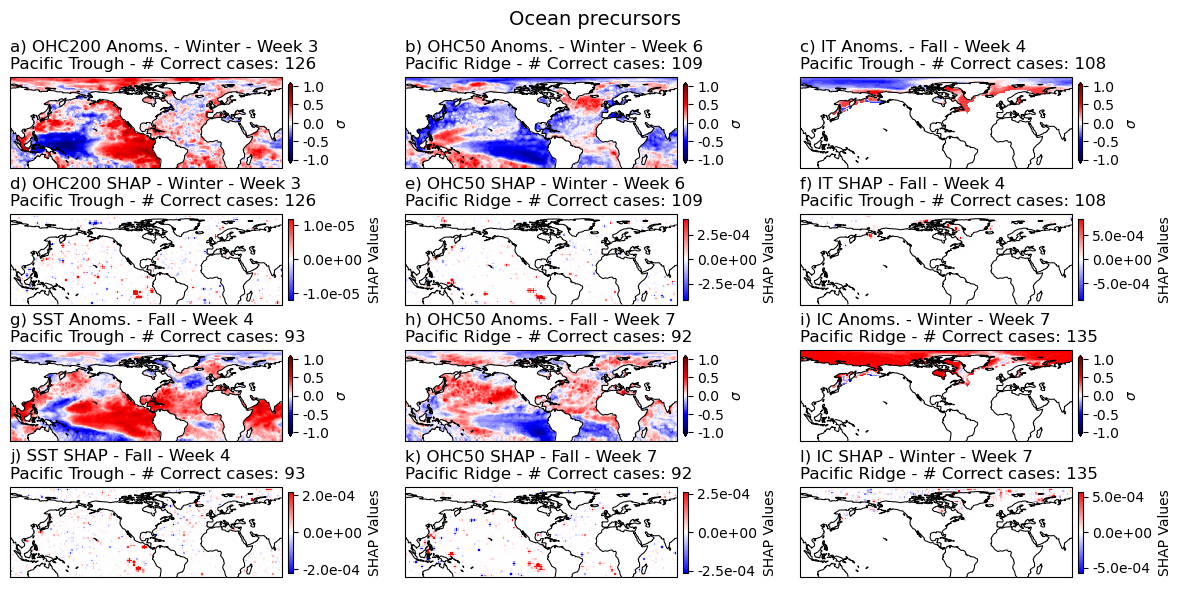

In [36]:
# fig, axs = plt.subplots(4, 3,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# # Flatten the axs array and convert to list
# axs_list = axs.flatten().tolist()

# shrink = 0.8

# plot_composite_in_ax(axs_list[0],4,3,0,'Winter','a',shrink=shrink)
# plot_shap_in_ax(axs_list[3],4,3,0,'Winter','d',shrink=shrink)

# plot_composite_in_ax(axs_list[1],6,6,1,'Winter','b',shrink=shrink)
# plot_shap_in_ax(axs_list[4],6,6,1,'Winter','e',shrink=shrink)

# plot_composite_in_ax(axs_list[6],12,4,0,'Fall','g',shrink=shrink)
# plot_shap_in_ax(axs_list[9],12,4,0,'Fall','j',shrink=shrink)

# plot_composite_in_ax(axs_list[7],6,7,1,'Fall','h',shrink=shrink)
# plot_shap_in_ax(axs_list[10],6,7,1,'Fall','k',shrink=shrink)

# plot_composite_in_ax(axs_list[2],1,4,0,'Fall','c',shrink=shrink)
# plot_shap_in_ax(axs_list[5],1,4,0,'Fall','f',shrink=shrink)
# plot_composite_in_ax(axs_list[8],0,7,1,'Winter','i',shrink=shrink)
# plot_shap_in_ax(axs_list[11],0,7,1,'Winter','l',shrink=shrink)

# fig.suptitle(f'Ocean precursors',fontsize=14,y=0.98)
# plt.tight_layout()
# plt.savefig('11_Ocean_Precursors.png')

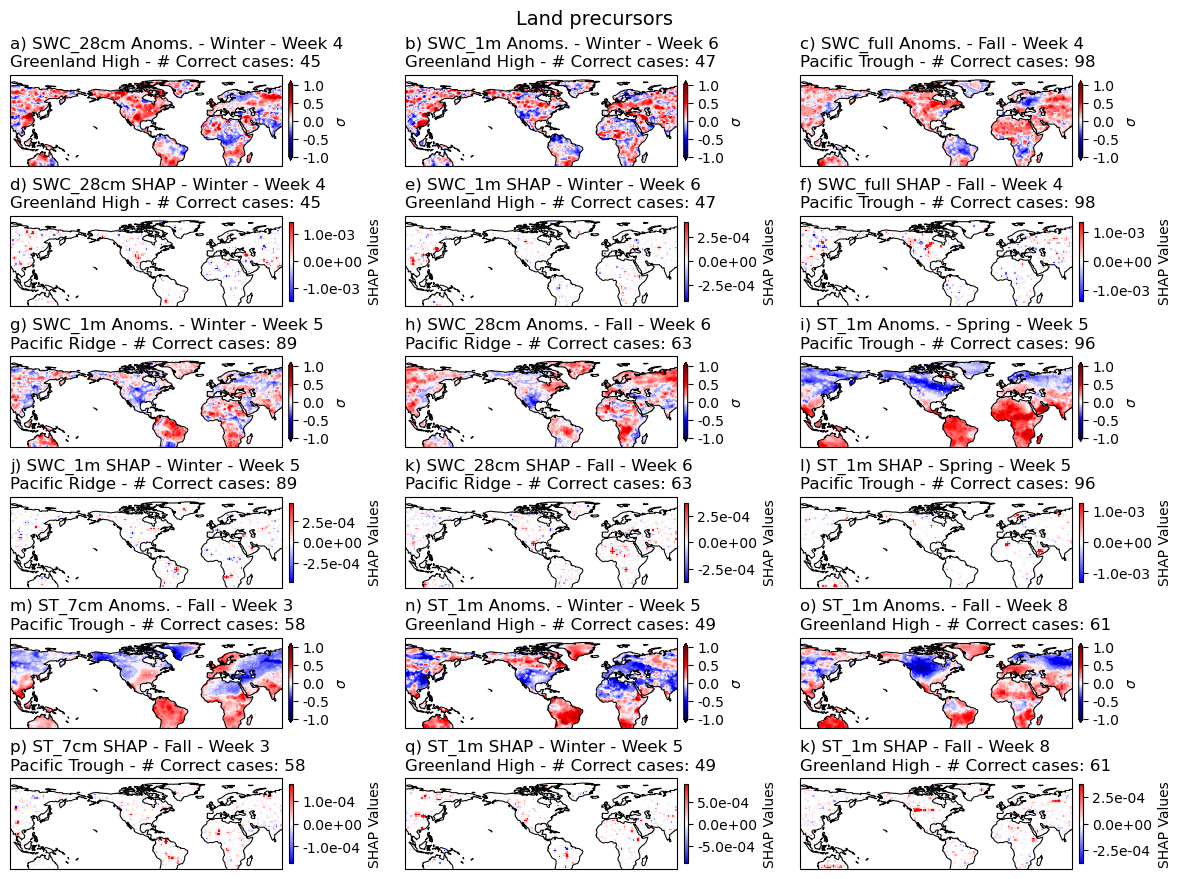

In [39]:
fig, axs = plt.subplots(6, 3,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

shrink=0.75

plot_composite_in_ax(axs_list[0],18,4,2,'Winter','a',shrink=shrink)
plot_shap_in_ax(axs_list[3],18,4,2,'Winter','d',shrink=shrink)

plot_composite_in_ax(axs_list[1],17,6,2,'Winter','b',shrink=shrink)
plot_shap_in_ax(axs_list[4],17,6,2,'Winter','e',shrink=shrink)

# plot_composite_in_ax(axs_list[2],17,7,2,'Winter','c')
# plot_shap_in_ax(axs_list[5],17,7,2,'Winter','f')

plot_composite_in_ax(axs_list[2],20,4,0,'Fall','c',shrink=shrink)
plot_shap_in_ax(axs_list[5],20,4,0,'Fall','f',shrink=shrink)

plot_composite_in_ax(axs_list[6],17,5,1,'Winter','g',shrink=shrink)
plot_shap_in_ax(axs_list[9],17,5,1,'Winter','j',shrink=shrink)

plot_composite_in_ax(axs_list[7],18,6,1,'Fall','h',shrink=shrink)
plot_shap_in_ax(axs_list[10],18,6,1,'Fall','k',shrink=shrink)

plot_composite_in_ax(axs_list[8],13,5,0,'Spring','i',shrink=shrink)
plot_shap_in_ax(axs_list[11],13,5,0,'Spring','l',shrink=shrink)

plot_composite_in_ax(axs_list[12],15,3,0,'Fall','m',shrink=shrink)
plot_shap_in_ax(axs_list[15],15,3,0,'Fall','p',shrink=shrink)

plot_composite_in_ax(axs_list[13],13,5,2,'Winter','n',shrink=shrink)
plot_shap_in_ax(axs_list[16],13,5,2,'Winter','q',shrink=shrink)

plot_composite_in_ax(axs_list[14],13,8,2,'Fall','o',shrink=shrink)
plot_shap_in_ax(axs_list[17],13,8,2,'Fall','k',shrink=shrink)

fig.suptitle(f'Land precursors',fontsize=14,y=0.98)
plt.tight_layout()
plt.savefig('12_SWC_ST_Precursors.png')

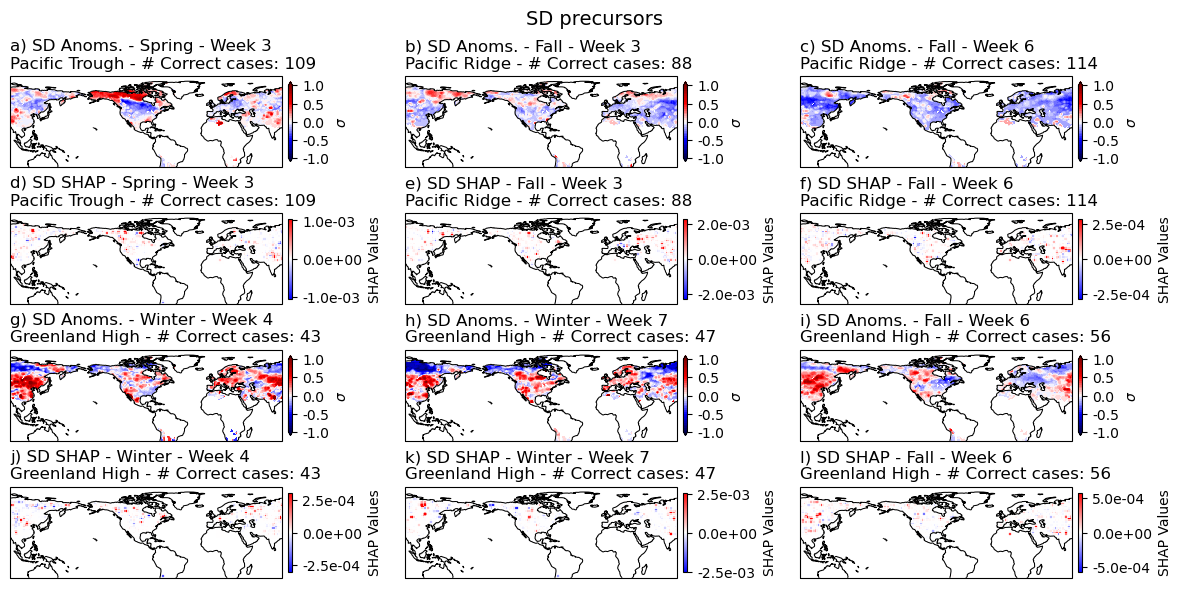

In [41]:
fig, axs = plt.subplots(4, 3,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

shrink=0.8

plot_composite_in_ax(axs_list[0],9,3,0,'Spring','a',shrink=shrink)
plot_shap_in_ax(axs_list[3],9,3,0,'Spring','d',shrink=shrink)

plot_composite_in_ax(axs_list[1],9,3,1,'Fall','b',shrink=shrink)
plot_shap_in_ax(axs_list[4],9,3,1,'Fall','e',shrink=shrink)

plot_composite_in_ax(axs_list[2],9,6,1,'Fall','c',shrink=shrink)
plot_shap_in_ax(axs_list[5],9,6,1,'Fall','f',shrink=shrink)

plot_composite_in_ax(axs_list[6],9,4,2,'Winter','g',shrink=shrink)
plot_shap_in_ax(axs_list[9],9,4,2,'Winter','j',shrink=shrink)

plot_composite_in_ax(axs_list[7],9,7,2,'Winter','h',shrink=shrink)
plot_shap_in_ax(axs_list[10],9,7,2,'Winter','k',shrink=shrink)

plot_composite_in_ax(axs_list[8],9,6,2,'Fall','i',shrink=shrink)
plot_shap_in_ax(axs_list[11],9,6,2,'Fall','l',shrink=shrink)

fig.suptitle(f'SD precursors',fontsize=14,y=0.98)
plt.tight_layout()
plt.savefig('13_SD_Precursors.png')

In [402]:
for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


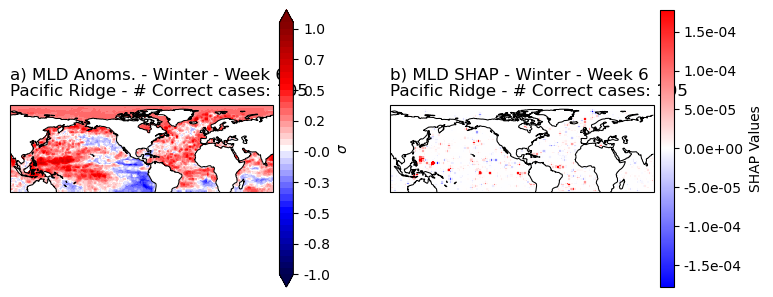

In [13]:
fig, axs = plt.subplots(1, 2,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()
plot_composite_in_ax(axs_list[0],2,6,1,'Winter','a')
plot_shap_in_ax(axs_list[1],2,6,1,'Winter','b')

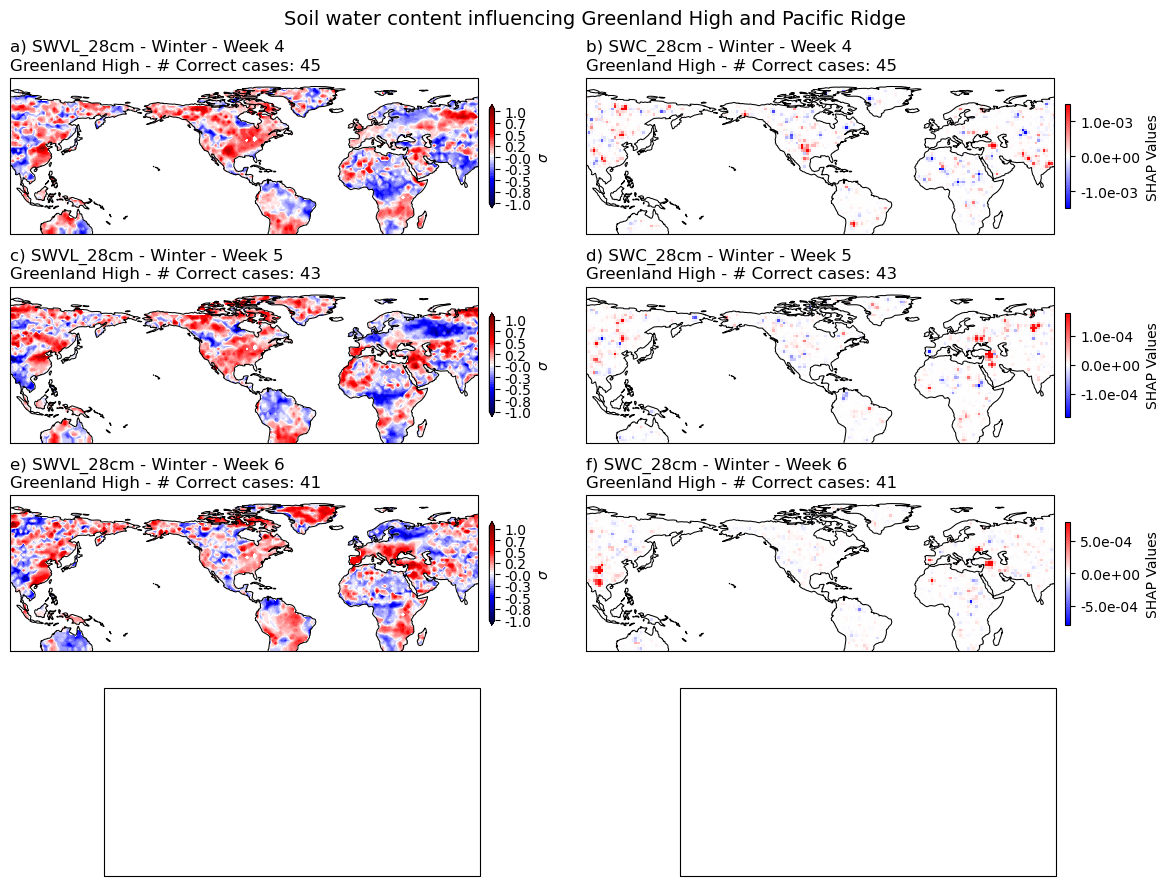

In [124]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],18,4,2,'Winter','a')
plot_shap_in_ax(axs_list[1],18,4,2,'Winter','b')
plot_composite_in_ax(axs_list[2],18,5,2,'Winter','c')
plot_shap_in_ax(axs_list[3],18,5,2,'Winter','d')
plot_composite_in_ax(axs_list[4],18,6,2,'Winter','e')
plot_shap_in_ax(axs_list[5],18,6,2,'Winter','f')

# plot_composite_in_ax(axs_list[4],21,6,1,'Winter','e')
# plot_shap_in_ax(axs_list[5],21,6,1,'Winter','f')
# plot_composite_in_ax(axs_list[6],21,7,1,'Winter','g')
# plot_shap_in_ax(axs_list[7],21,7,1,'Winter','h')

fig.suptitle(f'Soil water content influencing Greenland High and Pacific Ridge',fontsize=14,y=0.98)
plt.tight_layout()

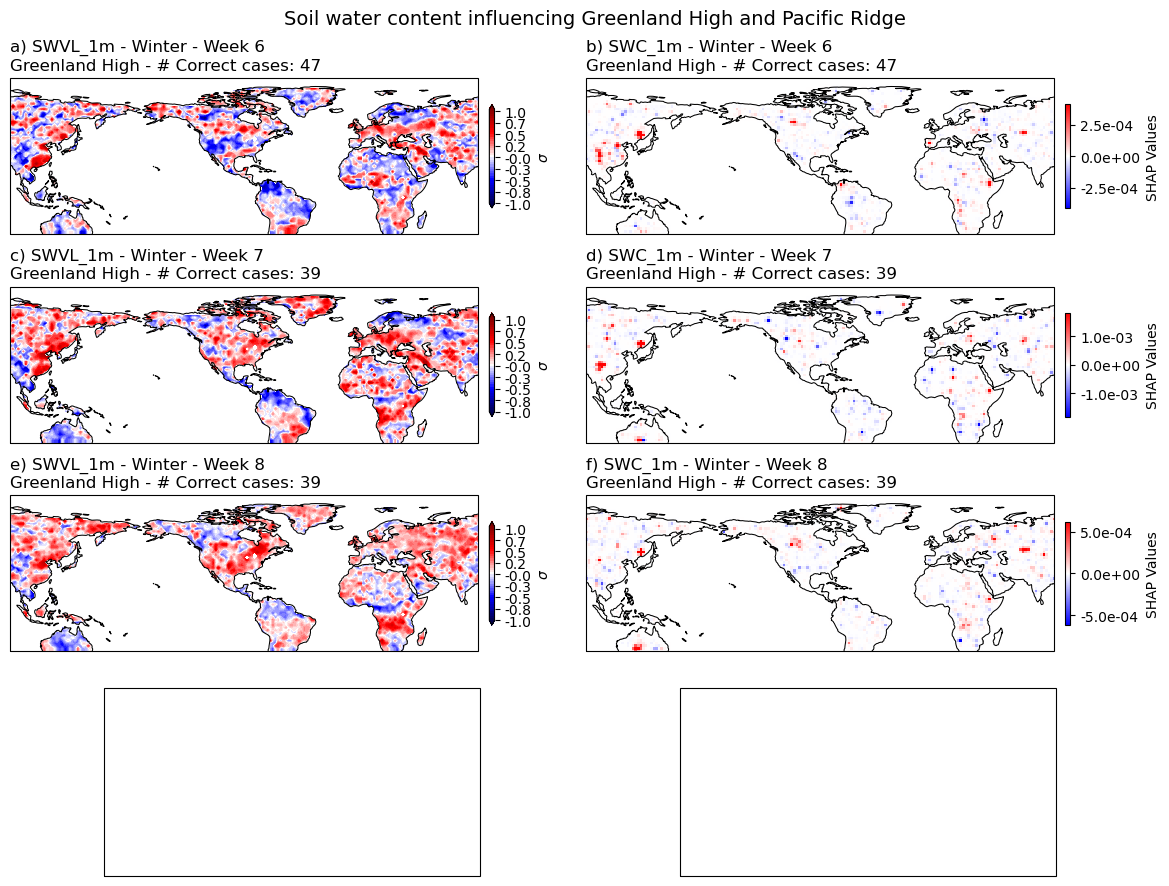

In [125]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],17,6,2,'Winter','a')
plot_shap_in_ax(axs_list[1],17,6,2,'Winter','b')
plot_composite_in_ax(axs_list[2],17,7,2,'Winter','c')
plot_shap_in_ax(axs_list[3],17,7,2,'Winter','d')
plot_composite_in_ax(axs_list[4],17,8,2,'Winter','e')
plot_shap_in_ax(axs_list[5],17,8,2,'Winter','f')

# plot_composite_in_ax(axs_list[4],21,6,1,'Winter','e')
# plot_shap_in_ax(axs_list[5],21,6,1,'Winter','f')
# plot_composite_in_ax(axs_list[6],21,7,1,'Winter','g')
# plot_shap_in_ax(axs_list[7],21,7,1,'Winter','h')

fig.suptitle(f'Soil water content influencing Greenland High and Pacific Ridge',fontsize=14,y=0.98)
plt.tight_layout()

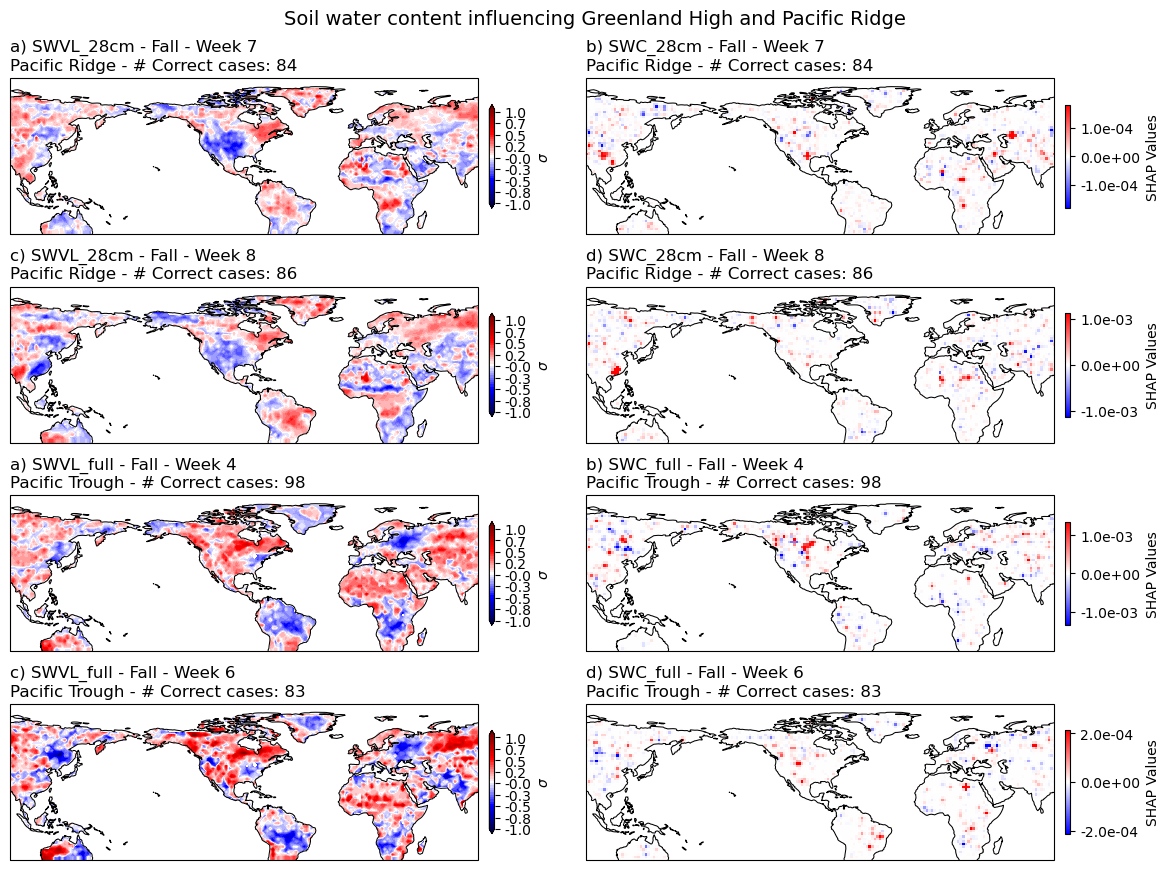

In [120]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],18,7,1,'Fall','a')
plot_shap_in_ax(axs_list[1],18,7,1,'Fall','b')
plot_composite_in_ax(axs_list[2],18,8,1,'Fall','c')
plot_shap_in_ax(axs_list[3],18,8,1,'Fall','d')

plot_composite_in_ax(axs_list[4],20,4,0,'Fall','a')
plot_shap_in_ax(axs_list[5],20,4,0,'Fall','b')
plot_composite_in_ax(axs_list[6],20,6,0,'Fall','c')
plot_shap_in_ax(axs_list[7],20,6,0,'Fall','d')

fig.suptitle(f'Soil water content influencing Greenland High and Pacific Ridge',fontsize=14,y=0.98)
plt.tight_layout()

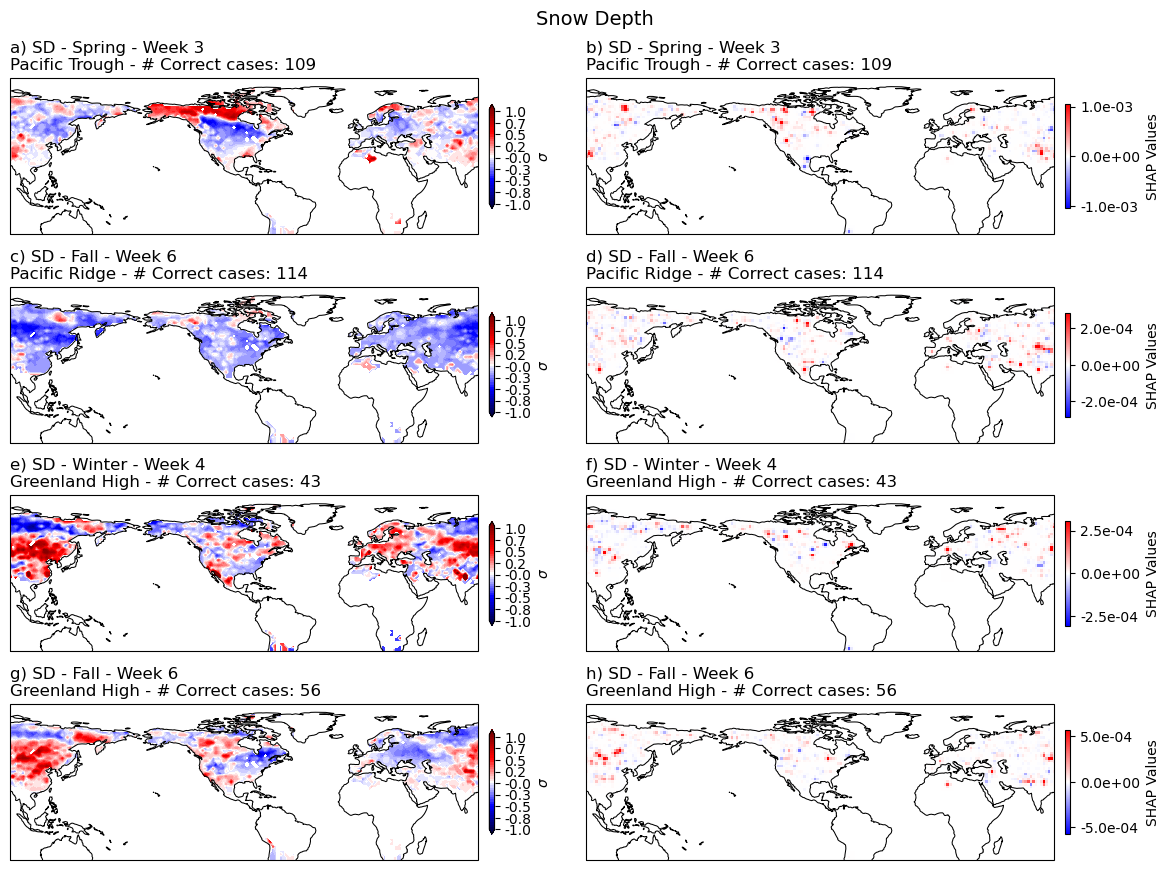

In [115]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],9,3,0,'Spring','a')
plot_shap_in_ax(axs_list[1],9,3,0,'Spring','b')

plot_composite_in_ax(axs_list[2],9,6,1,'Fall','c')
plot_shap_in_ax(axs_list[3],9,6,1,'Fall','d')

plot_composite_in_ax(axs_list[4],9,4,2,'Winter','e')
plot_shap_in_ax(axs_list[5],9,4,2,'Winter','f')

plot_composite_in_ax(axs_list[6],9,6,2,'Fall','g')
plot_shap_in_ax(axs_list[7],9,6,2,'Fall','h')

fig.suptitle(f'Snow Depth',fontsize=14,y=0.98)
plt.tight_layout()
plt.savefig('SD.pdf')

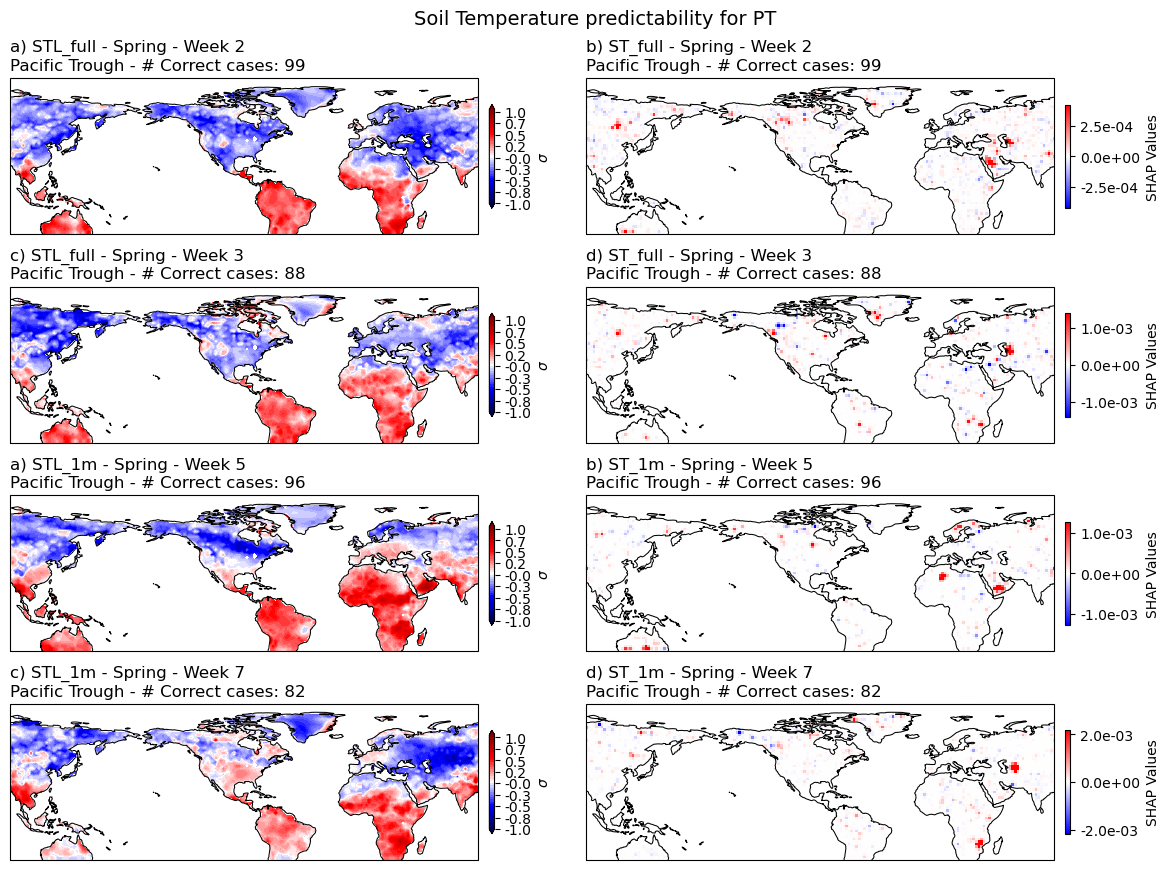

In [118]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],16,2,0,'Spring','a')
plot_shap_in_ax(axs_list[1],16,2,0,'Spring','b')

plot_composite_in_ax(axs_list[2],16,3,0,'Spring','c')
plot_shap_in_ax(axs_list[3],16,3,0,'Spring','d')

plot_composite_in_ax(axs_list[4],13,5,0,'Spring','a')
plot_shap_in_ax(axs_list[5],13,5,0,'Spring','b')

plot_composite_in_ax(axs_list[6],13,7,0,'Spring','c')
plot_shap_in_ax(axs_list[7],13,7,0,'Spring','d')

fig.suptitle(f'Soil Temperature predictability for PT',fontsize=14,y=0.98)
plt.tight_layout()
# plt.savefig('SD.pdf')

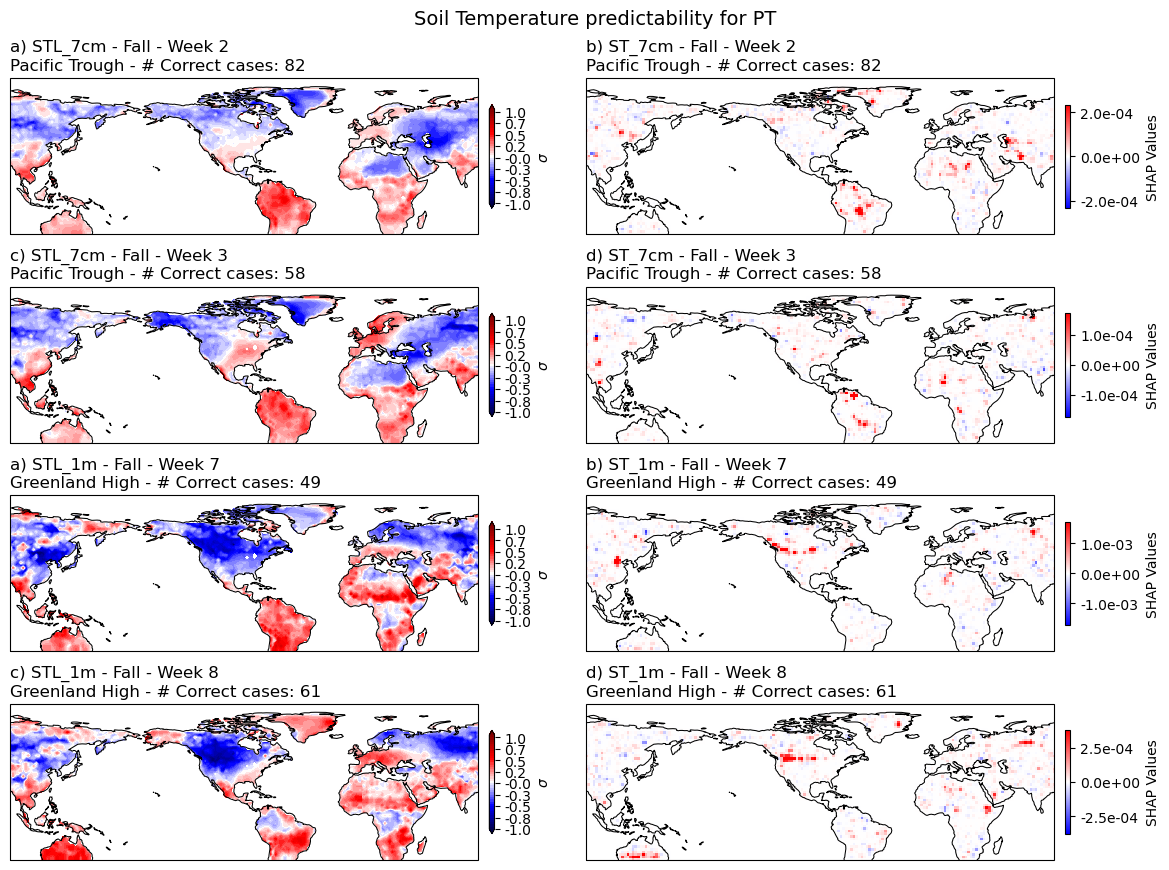

In [126]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

plot_composite_in_ax(axs_list[0],15,2,0,'Fall','a')
plot_shap_in_ax(axs_list[1],15,2,0,'Fall','b')

plot_composite_in_ax(axs_list[2],15,3,0,'Fall','c')
plot_shap_in_ax(axs_list[3],15,3,0,'Fall','d')

plot_composite_in_ax(axs_list[4],13,7,2,'Fall','a')
plot_shap_in_ax(axs_list[5],13,7,2,'Fall','b')

plot_composite_in_ax(axs_list[6],13,8,2,'Fall','c')
plot_shap_in_ax(axs_list[7],13,8,2,'Fall','d')

fig.suptitle(f'Soil Temperature predictability for PT',fontsize=14,y=0.98)
plt.tight_layout()
# plt.savefig('SD.pdf')

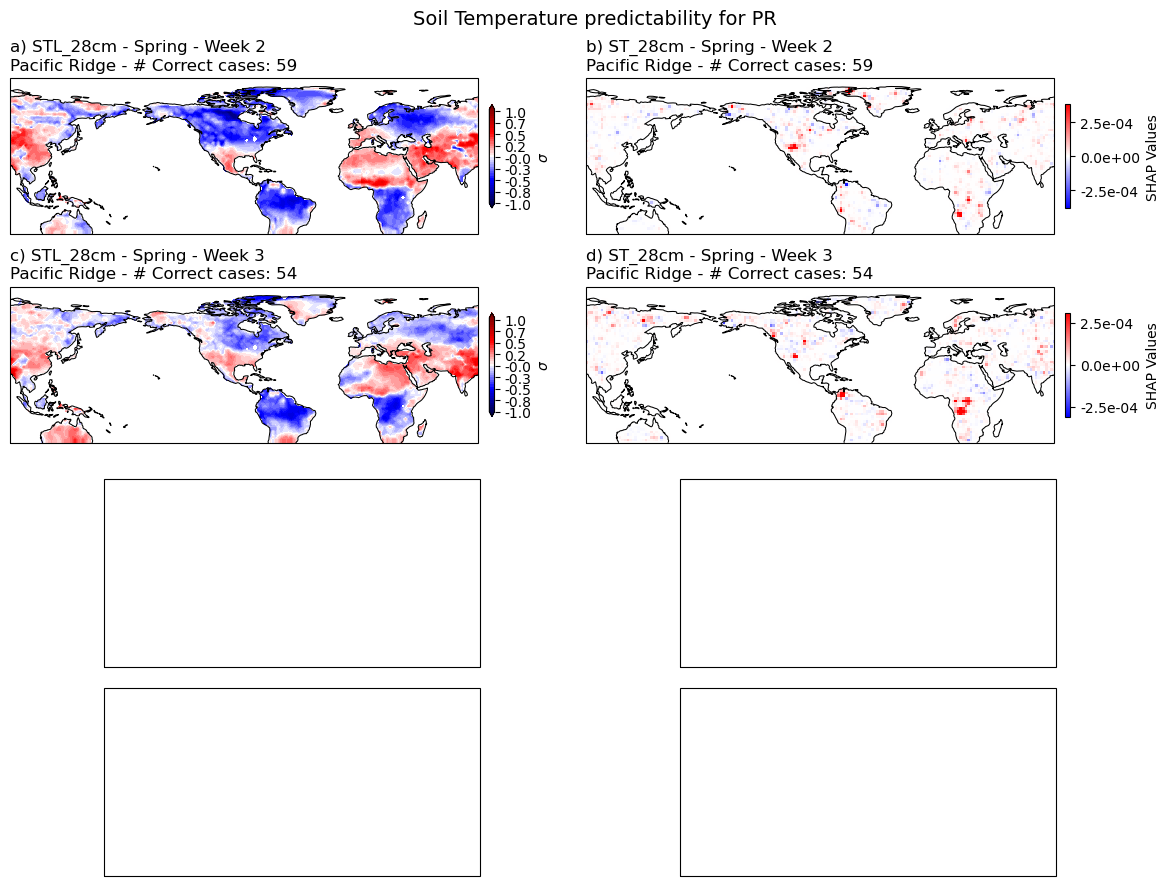

In [134]:
fig, axs = plt.subplots(4, 2,figsize=(12,9), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()


plot_composite_in_ax(axs_list[0],14,2,1,'Spring','a')
plot_shap_in_ax(axs_list[1],14,2,1,'Spring','b')

plot_composite_in_ax(axs_list[2],14,3,1,'Spring','c')
plot_shap_in_ax(axs_list[3],14,3,1,'Spring','d')

fig.suptitle(f'Soil Temperature predictability for PR',fontsize=14,y=0.98)
plt.tight_layout()
# plt.savefig('SD.pdf')